<a href="https://colab.research.google.com/github/klmurussi/fastaiOnCampus/blob/main/nbs/lesson03_180042378_klmurussi_Kathlyn_Lara_Murussi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecer os santos de bronze (Saint Seiya)

Esse notebook tem como objetivo diferenciar os quatro seguintes santos (cavaleiros) de bronze do anime Saint Seiya.

- Shiryu de Dragão
- Hyoga de Cisne
- Shun de Andrômeda
- Ikki de Fênix

## Passos

1. Instalar as bibliotecas do DuckDuckGo e do fastai, que utilizaremos para rodar este notebook;
2. Usar a API do DuckDuckGo API para baixar nosso dataset, imagens dos quatro santos de bronze, através dos termos "Shun cdz", "Hyoga cdz", "Ikki cdz" e "Shiryu cdz";
3. Verificar se todas as imagens foram baixadas corretamente e caso tenha que remover alguma;
4. Treinar o modelo:
- Criar o datablock;
- Treinar o modelo com os modelos resnet18, resnet50 e levit 384.
5. Análise dos resultados.

## 1. Instalando dependências

In [1]:
! pip install -Uqq fastai duckduckgo_search timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.5 MB/s eta 0:00:00


## 2. Baixando o dataset

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

searches = 'shiryu', 'shun', 'hyoga', 'ikki'

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
from fastdownload import download_url
from fastai.vision.all import *

path = Path('saints')
from time import sleep

for saint in searches:
    dest = (path/saint)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{saint} cdz'))
    sleep(10)
    resize_images(path/saint, max_size=400, dest=path/saint)

Searching for 'shiryu cdz'
Searching for 'shun cdz'
Searching for 'hyoga cdz'
Searching for 'ikki cdz'


## 3. Verificar a integridade dos dados

In [4]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

## 4. Treinar o modelo

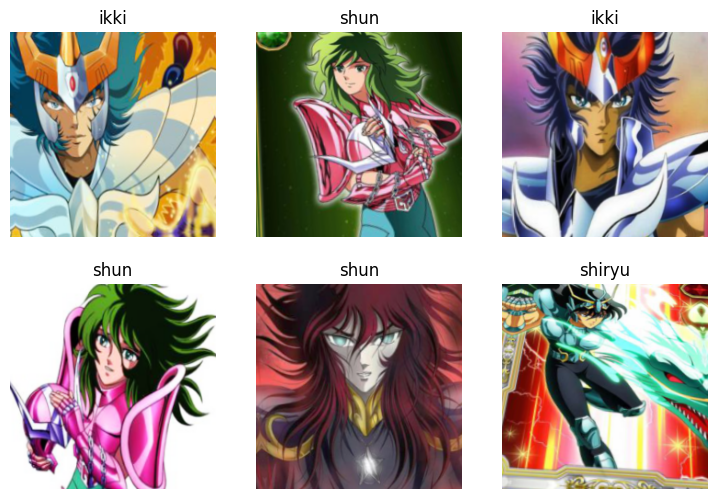

In [5]:
saint = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = saint.dataloaders(path)
dls.show_batch(max_n=6)

### 4.1. Modelo Resnet18

epoch,train_loss,valid_loss,error_rate,time
0,2.610710,5.030480,0.869565,00:17


epoch,train_loss,valid_loss,error_rate,time
0,2.346820,4.282738,0.869565,00:24
1,2.196337,3.577841,0.782609,00:25
2,2.148077,2.872927,0.782609,00:22
3,1.910191,2.154091,0.608696,00:22
4,1.681690,1.757814,0.608696,00:24


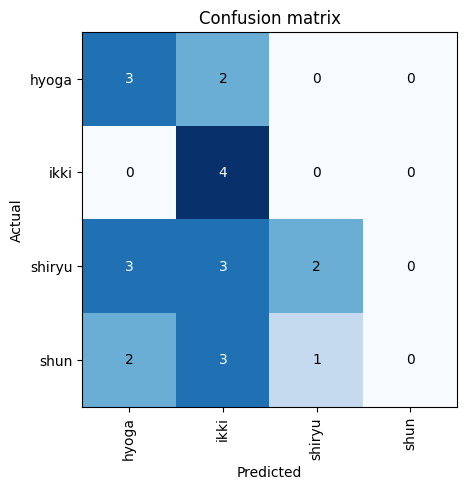

In [19]:
learnResnet18 = vision_learner(dls, resnet18, metrics = error_rate)
learnResnet18.fine_tune(5)
matriz = ClassificationInterpretation.from_learner(learnResnet18)
matriz.plot_confusion_matrix()

### 4.2. Modelo Resnet50

epoch,train_loss,valid_loss,error_rate,time
0,2.489306,1.569796,0.782609,00:47


epoch,train_loss,valid_loss,error_rate,time
0,1.855296,1.476902,0.739130,01:00
1,1.884097,1.361262,0.652174,01:01
2,1.591060,1.739201,0.608696,01:01
3,1.248223,1.719243,0.565217,01:00
4,1.042588,1.606521,0.521739,00:59


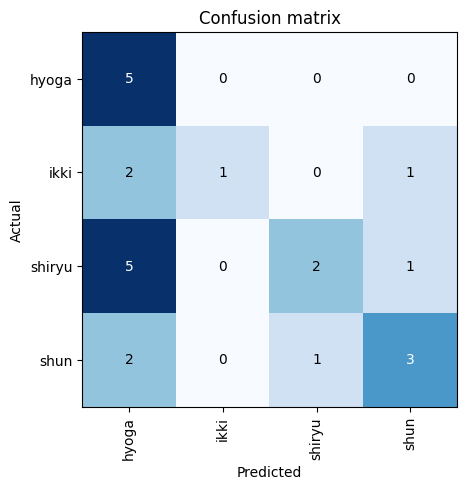

In [21]:
learnResnet50 = vision_learner(dls, resnet50, metrics = error_rate)
learnResnet50.fine_tune(5)
matriz = ClassificationInterpretation.from_learner(learnResnet50)
matriz.plot_confusion_matrix()

###4.3. Modelo Levit

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://dl.fbaipublicfiles.com/LeViT/LeViT-384-9bdaf2e2.pth" to /root/.cache/torch/hub/checkpoints/LeViT-384-9bdaf2e2.pth
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,2.582366,3.032250,0.782609,00:22


epoch,train_loss,valid_loss,error_rate,time
0,2.596098,2.842807,0.782609,00:29
1,2.286215,2.590495,0.782609,00:30
2,2.216842,2.357910,0.782609,00:30
3,2.083671,2.169265,0.739130,00:29
4,1.994590,2.110875,0.739130,00:30


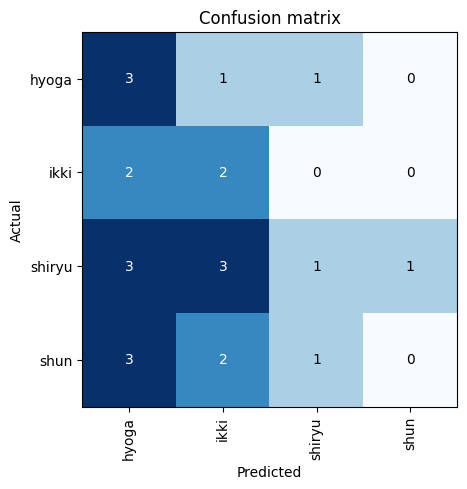

In [17]:
learnLevit = vision_learner(dls, 'levit_384', metrics=error_rate)
learnLevit.fine_tune(5)
matriz = ClassificationInterpretation.from_learner(learnLevit)
matriz.plot_confusion_matrix()

## 5. Análise dos resultados

Resnet18 e Resnet50: modelos ResNet (Residual Network) e diferem na quantidade de camadas. A resnet18 tem 18 camadas e a resnet50 tem 50 camadas. Tornando a resnet50 mais precisa, porém mais lenta que a resnet18.

Levit-234:  usa uma técnica chamada "Transformers", ele usa essa técnica para entender imagens e classificá-las com base no que vê. Teve a pior taxa de erro, mas é eficiente em termos de recursos computacionais.

## 6. Referências

https://course.fast.ai/Lessons/lesson3.html

https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning